## 4 Model Training

In [8]:
import pandas as pd
from happytransformer import HappyTextToText, TTSettings, TTTrainArgs
from tqdm import tqdm
import errant
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
happy_tt = HappyTextToText("text2text-generation", "pszemraj/grammar-synthesis-small")

args = TTTrainArgs(batch_size=8)
happy_tt.train("data/10k2.csv", args=args)
happy_tt.model.save_pretrained("../model/French_model")

### Load saved model

In [3]:
happy_tt = HappyTextToText("French", "../model/French_model")

args = TTSettings(num_beams=5, min_length=1, max_length=200)

sentence = 'I are happy'
result = happy_tt.generate_text("gec: " + sentence, args=args)
result.text

11/08/2023 15:35:27 - INFO - happytransformer.happy_transformer -   Using device: mps
11/08/2023 15:35:27 - INFO - happytransformer.happy_transformer -   Moving model to mps
11/08/2023 15:35:27 - INFO - happytransformer.happy_transformer -   Initializing a pipeline


'I am happy.'

### Evaluation

In [ ]:
happy_tt.eval("./data/10k2.csv")

### Comparison

In [ ]:
happy_tt2 = HappyTextToText("T5", "pszemraj/grammar-synthesis-small")

data = pd.read_csv("./data/10k2.csv")
data = data.head(100)

diffs = []

for i in tqdm(data.iterrows()):
    input = i[1]["input"]
    ourg = happy_tt.generate_text(input, args=args)
    theirg = happy_tt2.generate_text(input, args=args)
    if ourg != theirg:
        diffs.append([i[1]["input"], ourg.text, theirg.text])

df = pd.DataFrame(diffs, columns = ["original", "our", "old"])
df.to_csv("./data/diffs.csv")

### Plotting comparison

In [10]:
df = pd.read_csv('./data/diffs.csv')
df.head(5)

,Unnamed: 0,original,our,old
0,0,172; Commission also concurred with view of th...,172. Commission also concurred with view of th...,The Commission also concurred with the view of...
1,1,The Dark Enlightenment Part 1 The Dark Enlight...,The Dark Enlightenment Part 1 The Dark Enlight...,Veronica Cecilia Lodge is a main character in ...
2,2,Therefore quality nurses are in high demand no...,Therefore quality nurses are in high demand no...,"Therefore, quality nurses are in high demand n..."
3,3,There are many's that is apperes at this time ...,There are many that are apperes at this time i...,If I had to recommend one city next year then ...
4,4,Chaperon de disgrâce to top set match if don't...,Chaperon de Disgrâce top set match if don't wa...,Chaperon de disgrâce top set match if don't wa...


In [11]:
# setup errant annotator
nlp = spacy.load('en_core_web_sm')
annotator = errant.load('en', nlp)

def types_and_frequencies(col, df):
    error_types = []
    for i in tqdm(range(len(df))):
        temp_data = df.iloc[i]
        orig = annotator.parse(temp_data['original'])
        cor = annotator.parse(temp_data[col])
        edits = annotator.annotate(orig, cor)
        for e in edits:
            error_types.append(e.type)

    error_df = pd.DataFrame(columns = ['type'], data=error_types)
    value_counts = error_df.value_counts(normalize=True)
    freq = pd.DataFrame(value_counts)
    freq = freq.reset_index()
    return freq

In [12]:
# compute error frequencies are create dataframe for barplot
freq1 = types_and_frequencies('our', df)
freq2 = types_and_frequencies('old', df)
freq1['label'] = 'fine-tuned'
freq2['label'] = 'original'
total = pd.concat( [freq1, freq2], ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:01<00:00, 35.99it/s]


In [13]:
# rename column and sort values
total = total.rename(columns = {0:'proportion'})
total = total.sort_values(['type','label'], ascending=False)

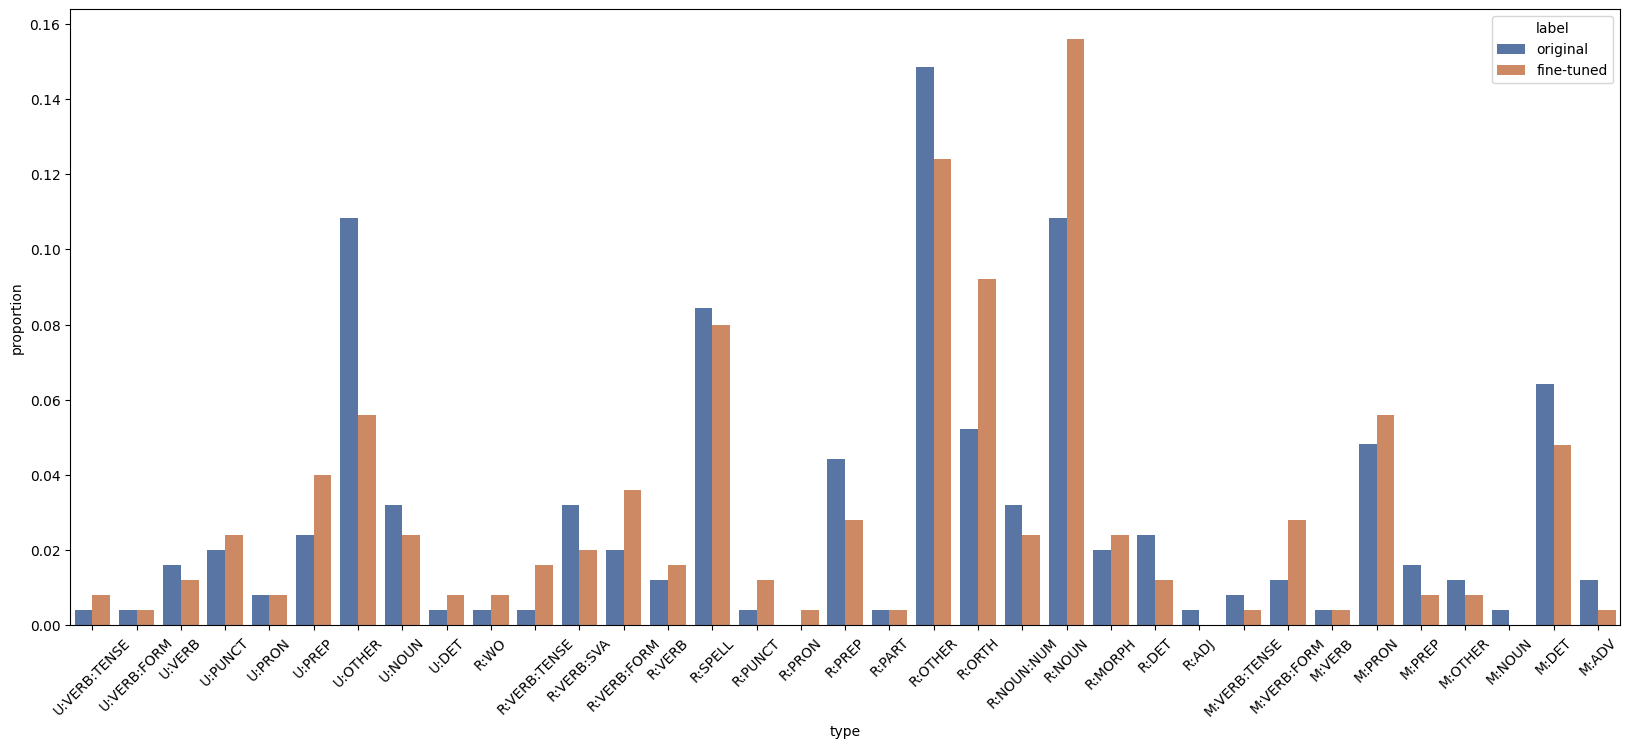

In [14]:
plt.figure(figsize=(20,8))
plt.xticks(rotation=45)
pl = sns.barplot(
    data=total,
    x="type", y='proportion', hue="label",
    palette="deep"
)
plt.show()